# zone by zone analysis

In [12]:
# this set up the  interactive visualisation mode for graphics.
%matplotlib notebook 
#%matplotlib inline
from operator import itemgetter
from itertools import groupby
import pandas as pd
import numpy as np
pd.set_option('display.max_rows',7) #only visualise 7 rows when displaying tables
from vega import vegalite
import vega
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import feature
from skimage import measure

In [35]:
tiff_file = "samples/CET01_08_rotated_z2.tif"

im = plt.imread(tiff_file)
im  = im[:,:,0]

In [36]:
plt.imshow(im,cmap=plt.cm.gray)

<IPython.core.display.Javascript object>


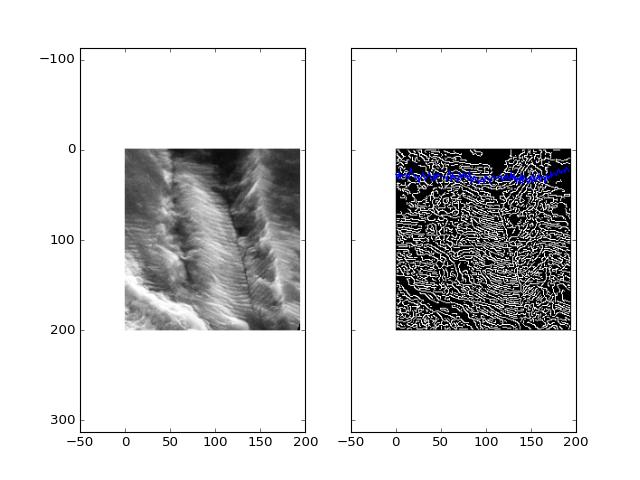

In [37]:
edges = feature.canny(im,sigma=0.5)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
ax1.imshow(im,cmap=plt.cm.gray)
ax2.imshow(edges,cmap=plt.cm.gray)

works really well , detect two edges per striation

In [38]:
j=np.where(np.any(edges==True, axis=0))

In [39]:
edges[:,1]

array([False,  True, False, False, False,  True,  True,  True, False,
       False, False, False,  True, False,  True, False, False,  True,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True, False,  True, False,
       False,  True, False,  True, False,  True, False, False,  True,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False,  True, False, False, False,  True, False,
        True,  True, False, False,  True,  True, False, False, False,
       False, False,

In [40]:
res1=[]
for k in range(edges.shape[1]):
    j, = np.where( edges[:,k]==True)
      
    ##res = np.sum(edges,axis=0)/2
    ##res = res[0:-1] ## remove the last value wich is always 0 by the algo
    ##res[0] = res[1]
    ranges = []
    data=j
    for key, group in groupby(enumerate(data), lambda i: i[0] - i[1]):
        group = list(map(itemgetter(1), group))


        if len(group) > 1:
                ranges.append(range(group[0], group[-1]))
        else:
                ranges.append(group[0])## extrapolate the fisrt value to the one just after
    res1.append(len(ranges)/2)

In [41]:
res = np.sum(edges,axis=0)/2
res = res[0:-1] ## remove the last value wich is always 0 by the algo
res[0] = res[1] ## extrapolate the fisrt value to the one just after
res1 = res1[0:-1] ## remove the last value wich is always 0 by the algo
res1[0] = res1[1] ## extrapolate the fisrt value to the one just after

In [42]:
plt.plot(res)

In [43]:
s1 = pd.Series(res1)
r1 = s1.rolling(window=50,center=True,min_periods=3).mean()
##df = pd.DataFrame({'Analyse':s1, 'Moyenne glissante':r1})

In [44]:
s = pd.Series(res)
r = s.rolling(window=50,center=True,min_periods=3).mean()
df = pd.DataFrame({'Analyse':s, 'Moyenne glissante':r,'Analyse1':s1, 'Moyenne glissante1':r1})

In [ ]:
df.plot()

In [15]:
fig, (ax1, ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=, sharex=True, sharey=False)
ax1.imshow(im,cmap=plt.cm.gray)
r.plot(ax=ax2)
ax1.set_title('Image originale')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax2.set_title('Compte des stries')
ax2.set_xlabel('x')
ax2.set_ylabel('nb de stries [-]')

<IPython.core.display.Javascript object>

In [16]:
fig.savefig('sample1.png')

# Deploying the strategy 

In [17]:
def analyse(filename):
    im = plt.imread(filename)
    im  = im[:,:,0]
    edges = feature.canny(im,sigma=0.5)
    res = np.sum(edges,axis=0)/2
    res = res[0:-1] ## remove the last value wich is always 0 by the algo
    res[0] = res[1] ## extrapolate the fisrt value to the one just after
    s = pd.Series(res)
    r = s.rolling(window=50,center=True,min_periods=3).mean()
    df = pd.DataFrame({'Analyse':s, 'Moyenne glissante':r})
    return {'im': im, 'edges':edges, 'df':df}

def plot_edges(im, edges):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
    ax1.imshow(im,cmap=plt.cm.gray)
    ax2.imshow(edges,cmap=plt.cm.gray)
    return fig

def plot_analysis(im, r, width=8):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(width, 6))
    ax1.imshow(im,cmap=plt.cm.gray)
    r.plot(ax=ax2)
    ax1.set_title('Image originale')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax2.set_title('Compte des stries')
    ax2.set_xlabel('x')
    ax2.set_ylabel('nb de stries [-]')
    return fig

# sample by sample

In [18]:
tiff_files = ["CET01_08_rotated_z2.tif", "CET01_08_rotated_z3.tif", "CET01_08_rotated_z4.tif","CET01_08_rotated_z1.tif"]

In [19]:
res = [ analyse(x) for x in tiff_files]

FileNotFoundError: [Errno 2] No such file or directory: 'CET01_08_rotated_z2.tif'

In [ ]:
n=2
fig = plot_edges(res[n]['im'],res[n]['edges'])

In [ ]:
n=3
fig = plot_analysis(res[n]['im'],res[n]['df']['Moyenne glissante'],width=10)


In [ ]:
fig.savefig('sample' + str(n) + '.png',frameon=True)